In [1]:
from seagul.rl.ars.ars_pipe import ars
from seagul.nn import MLP
import torch
import matplotlib.pyplot as plt
from seagul.mesh import create_mesh, variation_dim, mesh_dim, create_box_mesh
import time
import copy
import gym
import torch

import xarray as xr
import numpy as np
import pandas as pd

import os

ImportError: cannot import name 'mesh_dim'

In [7]:
def identity(rews,obs,acts):
    return rews

def vardiv(rews, obs, acts):
    return rews/variation_dim(obs)

def varmul(rews, obs, acts):
    return rews*variation_dim(obs)

def rough_measure(x):
    d = torch.stack([x[t,:] - x[t-1,:] for t in range(1,x.shape[0])])
    return d.std()#$/(torch.abs(d.mean()))

def rmul(rews, obs, acts):
    return rews*rough_measure(obs)

def rdiv(rews, obs, acts):
    return rews/rough_measure(obs)

def pcastd(rews, obs, acts):
    pca = PCA()
    pca.fit((obs - obs.mean())/obs.std())
    return rews*pca.explained_variance_ratio_.std()


def madodiv(rews, obs, acts):
    return rews/variation_dim(obs, order=1)

def variodiv(rews, obs, acts):
    return rews/variation_dim(obs, order=2)

def radodiv(rews, obs, acts):
    return rews/variation_dim(obs, order=.5)

def mdim_div(rews, obs, acts):
    if obs.shape[0] == 1000:
        gait_start = 200
        m,_,_,_ = mesh_dim(obs[gait_start:])
        m = np.clip(m, 1, obs.shape[1]/2)
    else:
        m = obs.shape[1]/2

    return rews/m
    
def cdim_mul(rews, obs, acts):
    _,c,_,_ = mesh_dim(obs)
    return c*rews

def cdim_div(rews, obs, acts):

    if obs.shape[0] == 1000:
        gait_start = 200
        _,c,_,_ = mesh_dim(obs[gait_start:])
        c = np.clip(c, 1, obs.shape[1]/2)
    else:
        c = obs.shape[1]/2

    return rews/c


def do_rollout(env, policy, render=False):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while not done:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        if render:
            env.render()
            time.sleep(.05)

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length


def do_long_rollout(env, policy, ep_length):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while cur_step < ep_length:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length

# Data 4 identity, vardiv, rmul

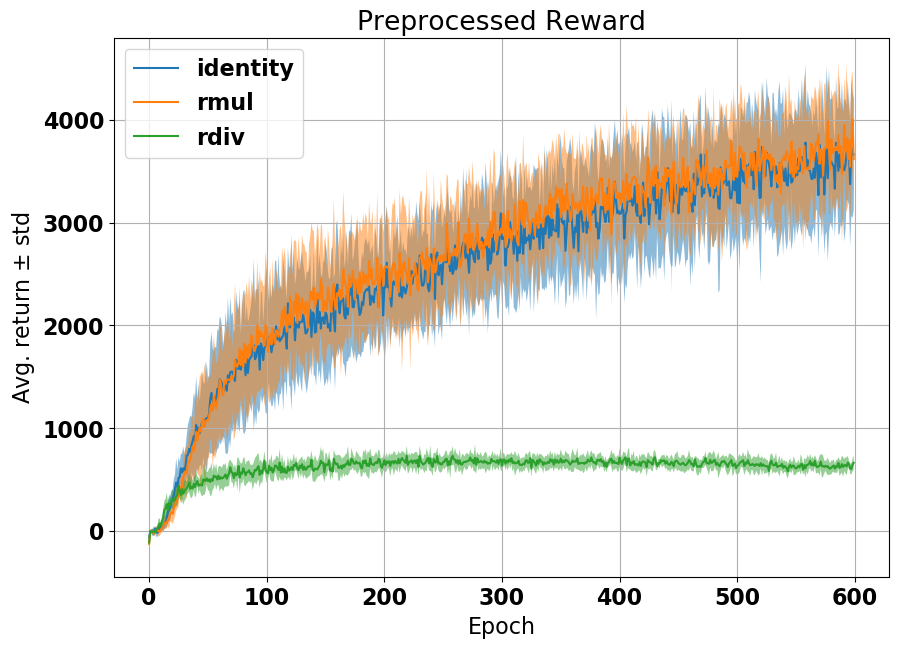

<Figure size 640x480 with 0 Axes>

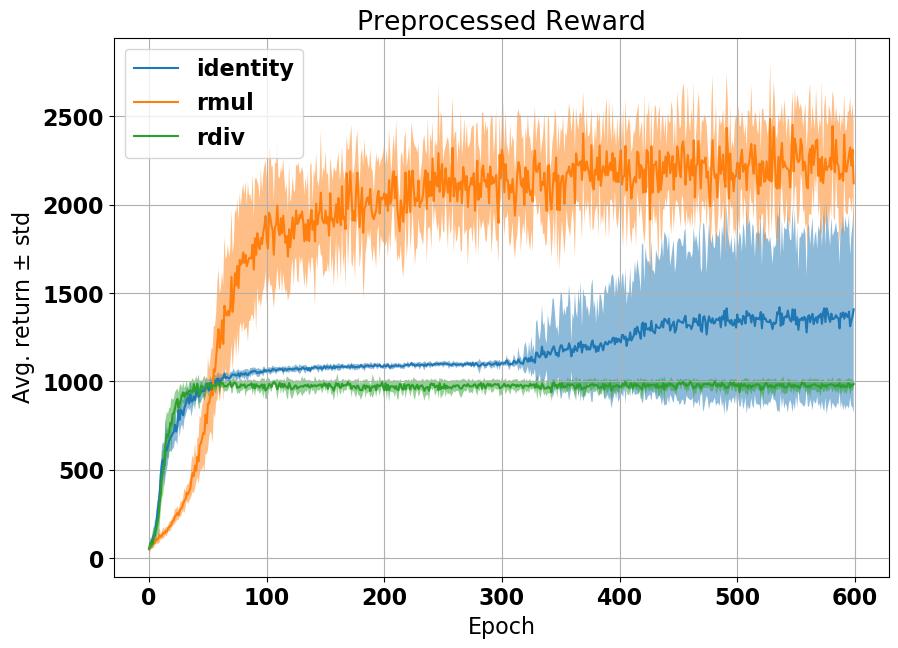

<Figure size 640x480 with 0 Axes>

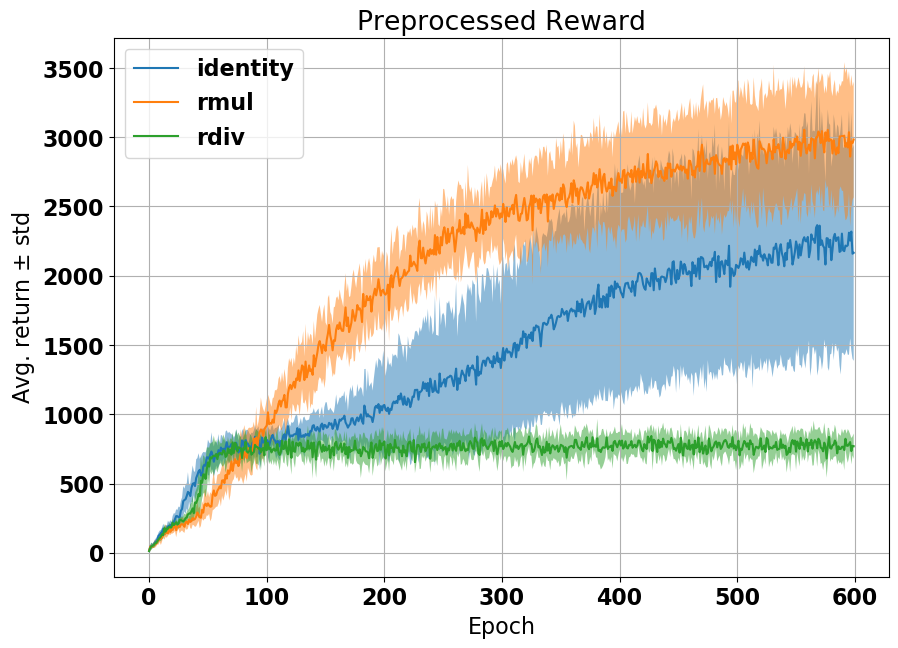

<Figure size 640x480 with 0 Axes>

In [111]:
# #data = torch.load("./datacdim2/Hopper-v2.xr")
# env_names = ['Walker2d-v2', 'Hopper-v2', 'HalfCheetah-v2']
# for env_name in env_names:
#     data = torch.load(f"./data4/{env_name}.xr")

#     policy_dict = data.policy_dict
#     rews = data.rews#/data.post_rews
#     exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
#     num_seeds = len(policy_dict[exp_names[0]])

#     means = rews.mean(dim="trial")
#     stds = rews.std(dim="trial")

#     plt.plot(means.T)
#     plt.legend(exp_names)
#     ci = stds

#     for mean, c in zip(means, ci):
#         plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
#     plt.title(f"Preprocessed Reward {env_name}")
#     plt.figure()

#     # for exp_name in exp_names:  
#     #     plt.plot(rews.loc[exp_name].T[:,0:10])
#     #     plt.title(exp_name)
#     #     plt.figure()
#     # top_seeds = {'identity':[0,1], 'cdim_div':[0,1]}
    
    
import matplotlib

#matplotlib.style.use('seaborn')
matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)


#data = torch.load("./datacdim2/Hopper-v2.xr")
env_names = ['HalfCheetah-v2', 'Hopper-v2', 'Walker2d-v2']
for env_name in env_names:
    #data = torch.load(f"./data4/{env_name}.xr").where(data.post!='radodiv')
    data = torch.load(f"./data4/{env_name}.xr")

    policy_dict = data.policy_dict
    rews = data.rews.loc[['identity', 'rmul', 'rdiv']]#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    plt.subplots(1,1, figsize=(10,7))
    plt.plot(means.T)
    plt.legend(exp_names, loc='upper left')
    ci = stds

    for mean, c in zip(means, ci):
        plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
    plt.title(f"Preprocessed Reward")
    plt.ylabel(r"Avg. return $\pm$ std")
    plt.xlabel(r"Epoch")
    plt.grid()
    plt.figure()

#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.title(exp_name)
#         plt.figure()
#     top_seeds = {'identity':[0,1], 'cdim_div':[0,1]}

In [113]:
for env_name in env_names:
    env = gym.make(env_name)
    data = torch.load(f"./data4/{env_name}.xr")
    policy_dict = data.policy_dict
    init_d = 1e-6
    num_runs = 5; num_seeds=10
    post_fns = [identity, vardiv, rmul, rdiv]
    ep_length= 1000


    mshdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    rews =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    for post_fn in post_fns:
        for i in range(num_seeds):
            for j in range(num_runs):
                policy = policy_dict[post_fn.__name__][i]
                o,a,r,l = do_long_rollout(env, policy, ep_length=ep_length)
                target = o[200:]
                target = (target - policy.state_means)/(policy.state_std)
                #target = (target - target.mean(dim=0))/(target.std(dim=0))


                rews.loc[post_fn.__name__,i,j] = sum(r).item()

                #mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d)
                #mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
                #vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
                #rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                

    print(f"{env_name}:")           
    print("madogram dimension")
    for fn in post_fns:
        mean = mdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = mdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for fn in post_fns:
        mean = vdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = vdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("radogram dimension")
    for fn in post_fns:
        mean = rdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = rdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for fn in post_fns:
        mean = mshdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = mshdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for fn in post_fns:
        mean = cdims.mean(dim=('seed', 'run')).loc[fn.__name__].item()
        std = cdims.std(dim=('seed', 'run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for fn in post_fns:
        mean = rews.mean(dim=('seed', 'run')).loc[fn.__name__].item()
        std = rews.std(dim=('seed', 'run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print(); print()


HalfCheetah-v2:
madogram dimension
identity mean: 0.0, std: 0.0
vardiv mean: 0.0, std: 0.0
rmul mean: 0.0, std: 0.0
rdiv mean: 0.0, std: 0.0

variogram dimension
identity mean: 0.0, std: 0.0
vardiv mean: 0.0, std: 0.0
rmul mean: 0.0, std: 0.0
rdiv mean: 0.0, std: 0.0

radogram dimension
identity mean: 0.0, std: 0.0
vardiv mean: 0.0, std: 0.0
rmul mean: 0.0, std: 0.0
rdiv mean: 0.0, std: 0.0

mesh dimension
identity mean: 0.0, std: 0.0
vardiv mean: 0.0, std: 0.0
rmul mean: 0.0, std: 0.0
rdiv mean: 0.0, std: 0.0

cmesh dimension
identity mean: 0.0, std: 0.0
vardiv mean: 0.0, std: 0.0
rmul mean: 0.0, std: 0.0
rdiv mean: 0.0, std: 0.0

rewards
identity mean: 5171.34353515625, std: 891.6793286790672
vardiv mean: 4806.736181640625, std: 749.8389790190996
rmul mean: 4965.533188476563, std: 844.4529514078879
rdiv mean: 876.7103991699219, std: 81.62290070913164


Hopper-v2:
madogram dimension
identity mean: 0.0, std: 0.0
vardiv mean: 0.0, std: 0.0
rmul mean: 0.0, std: 0.0
rdiv mean: 0.0, std: 0

In [ ]:

print(f"{env_name}:")           
print("madogram dimension")
for fn in post_fns:
    mean = mdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = mdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

print()
print("variogram dimension")
for fn in post_fns:
    mean = vdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = vdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

print()
print("radogram dimension")
for fn in post_fns:
    mean = rdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = rdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

print()
print("mesh dimension")
for fn in post_fns:
    mean = mshdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = mshdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

print()
print("cmesh dimension")
for fn in post_fns:
    mean = cdims.mean(dim=('seed', 'run')).loc[fn.__name__].item()
    std = cdims.std(dim=('seed', 'run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

print()
print("rewards")
for fn in post_fns:
    mean = rews.mean(dim=('seed', 'run')).loc[fn.__name__].item()
    std = rews.std(dim=('seed', 'run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

print(); print()

# Data 17

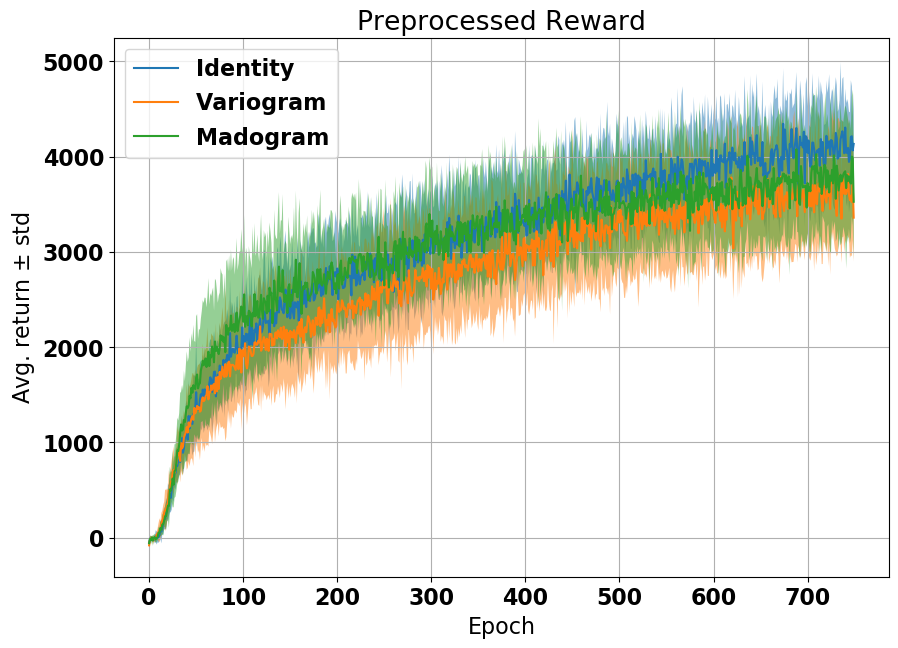

<Figure size 640x480 with 0 Axes>

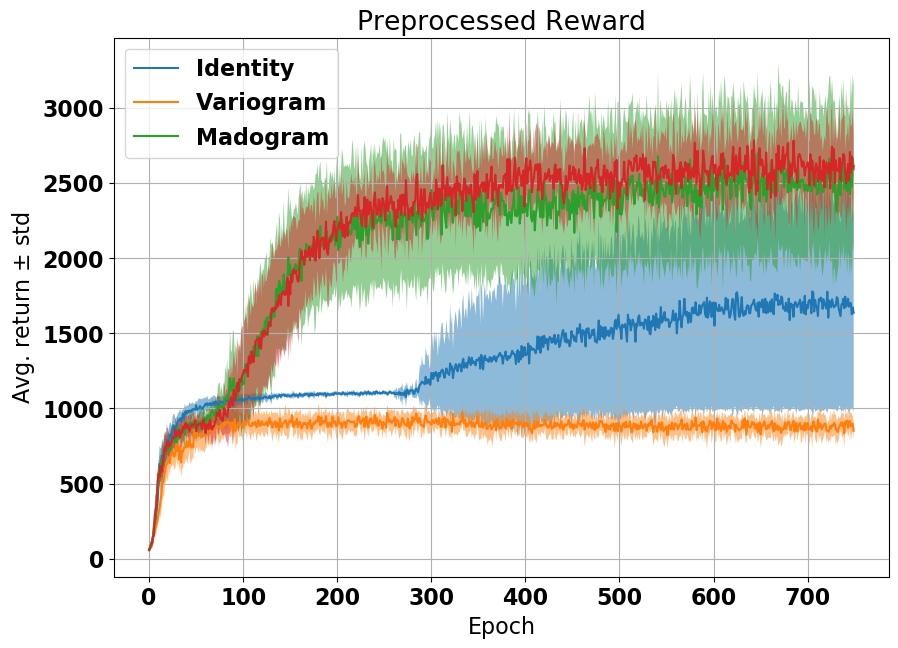

<Figure size 640x480 with 0 Axes>

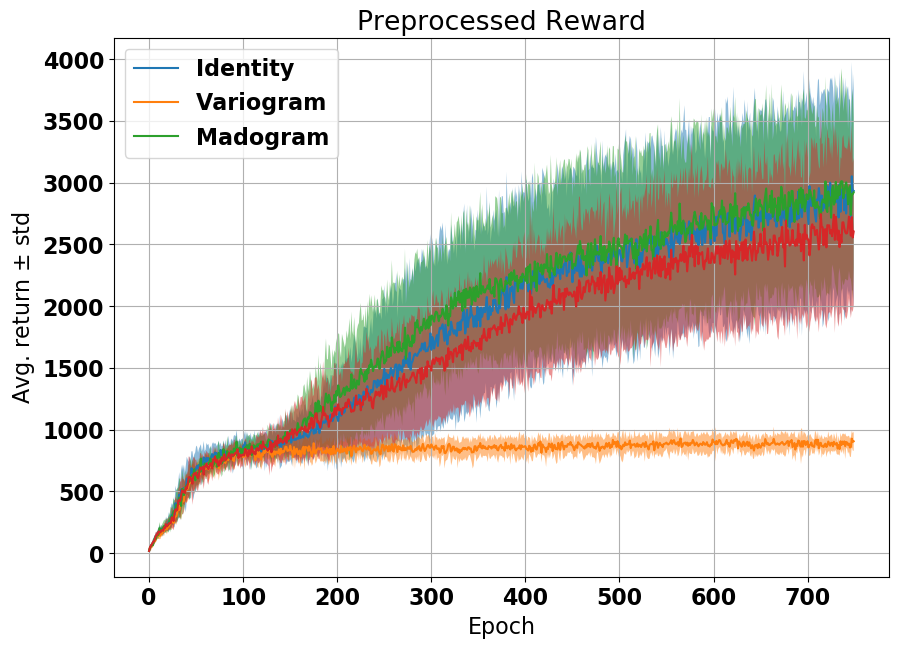

<Figure size 640x480 with 0 Axes>

In [168]:
import matplotlib

#matplotlib.style.use('seaborn')
matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)


#data = torch.load("./datacdim2/Hopper-v2.xr")
env_names = ['HalfCheetah-v2', 'Hopper-v2', 'Walker2d-v2']
for env_name in env_names:
    data = torch.load(f"./data17/{env_name}.xr")
    #data = data.where(data.post!='radodiv')

    policy_dict = data.policy_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    plt.subplots(1,1, figsize=(10,7))
    plt.plot(means.T)
    plt.legend(['Identity', 'Variogram','Madogram'], loc='upper left')
    ci = stds

    for mean, c in zip(means, ci):
        plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
    plt.title(f"Preprocessed Reward")
    plt.ylabel(r"Avg. return $\pm$ std")
    plt.xlabel(r"Epoch")
    plt.grid()
    plt.figure()

#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.title(exp_name)
#         plt.figure()
#     top_seeds = {'identity':[0,1], 'cdim_div':[0,1]}

In [172]:
env = gym.make(env_name)
data = torch.load(f"./data17/{env_name}.xr")
policy_dict = data.policy_dict
do_rollout(env, policy_dict['madodiv'][2], render=True)

Creating window glfw


KeyboardInterrupt: 

In [127]:
for env_name in env_names:
    env = gym.make(env_name)
    data = torch.load(f"./data17/{env_name}.xr")
    policy_dict = data.policy_dict
    init_d = 1e-6
    num_runs = 5; num_seeds=10
    post_fns = [identity, variodiv, madodiv]
    ep_length= 1000


    mshdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    rews =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    for post_fn in post_fns:
        for i in range(num_seeds):
            for j in range(num_runs):
                policy = policy_dict[post_fn.__name__][i]
                o,a,r,l = do_long_rollout(env, policy, ep_length=ep_length)
                target = o[200:]
                target = (target - policy.state_means)/(policy.state_std)
                #target = (target - target.mean(dim=0))/(target.std(dim=0))


                rews.loc[post_fn.__name__,i,j] = sum(r).item()

#                 mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d)
#                 mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
#                 vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
#                 rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                

    print(f"{env_name}:")           
    print("madogram dimension")
    for fn in post_fns:
        mean = mdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = mdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for fn in post_fns:
        mean = vdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = vdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("rodogram dimension")
    for fn in post_fns:
        mean = rdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = rdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for fn in post_fns:
        mean = mshdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = mshdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for fn in post_fns:
        mean = cdims.mean(dim=('seed', 'run')).loc[fn.__name__].item()
        std = cdims.std(dim=('seed', 'run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for fn in post_fns:
        mean = rews.mean(dim=('seed', 'run')).loc[fn.__name__].item()
        std = rews.std(dim=('seed', 'run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print(); print()

HalfCheetah-v2:
madogram dimension
identity mean: 0.0, std: 0.0
variodiv mean: 0.0, std: 0.0
madodiv mean: 0.0, std: 0.0

variogram dimension
identity mean: 0.0, std: 0.0
variodiv mean: 0.0, std: 0.0
madodiv mean: 0.0, std: 0.0

rodogram dimension
identity mean: 0.0, std: 0.0
variodiv mean: 0.0, std: 0.0
madodiv mean: 0.0, std: 0.0

mesh dimension
identity mean: 0.0, std: 0.0
variodiv mean: 0.0, std: 0.0
madodiv mean: 0.0, std: 0.0

cmesh dimension
identity mean: 0.0, std: 0.0
variodiv mean: 0.0, std: 0.0
madodiv mean: 0.0, std: 0.0

rewards
identity mean: 5545.999619140625, std: 593.8769940808644
variodiv mean: 5136.002861328125, std: 851.9177511359011
madodiv mean: 5234.127109375, std: 950.6454916922088


Hopper-v2:
madogram dimension
identity mean: 0.0, std: 0.0
variodiv mean: 0.0, std: 0.0
madodiv mean: 0.0, std: 0.0

variogram dimension
identity mean: 0.0, std: 0.0
variodiv mean: 0.0, std: 0.0
madodiv mean: 0.0, std: 0.0

rodogram dimension
identity mean: 0.0, std: 0.0
variodiv me

# Data mcshdim4

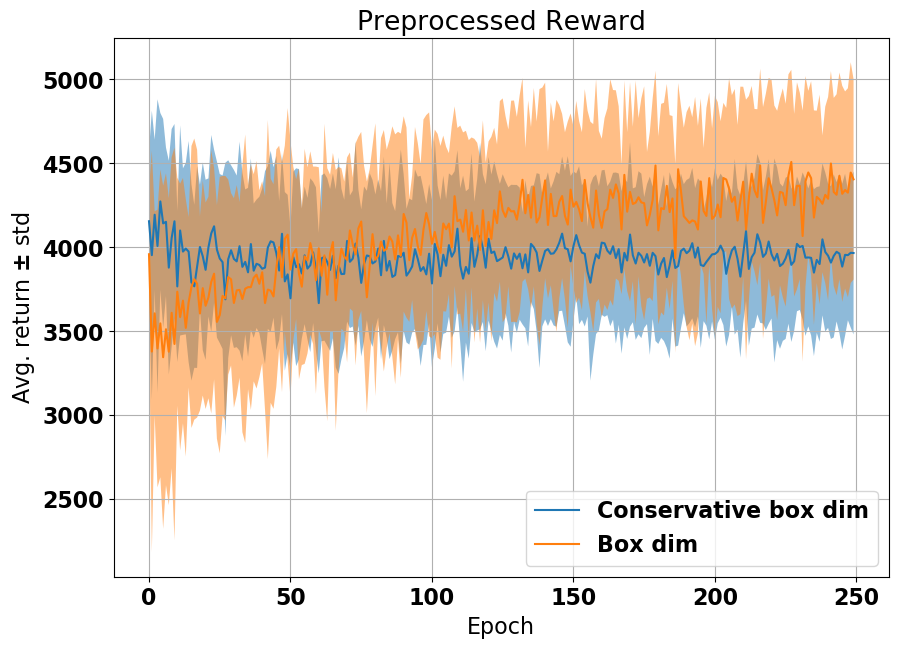

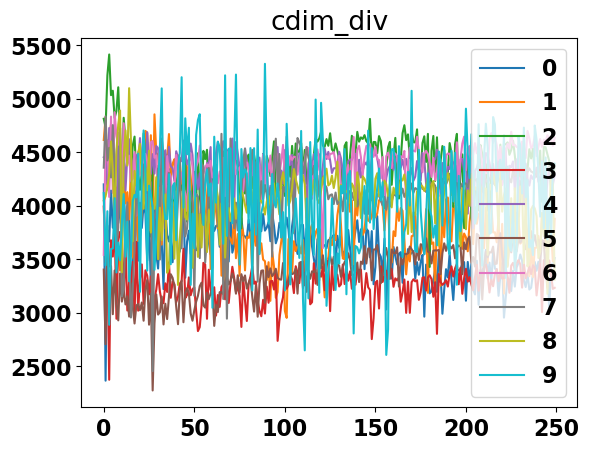

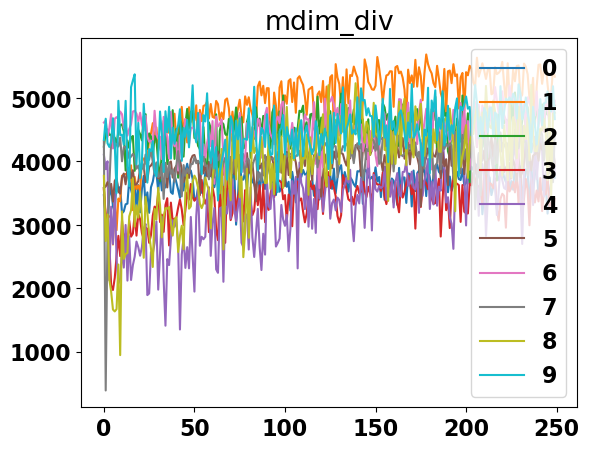

<Figure size 640x480 with 0 Axes>

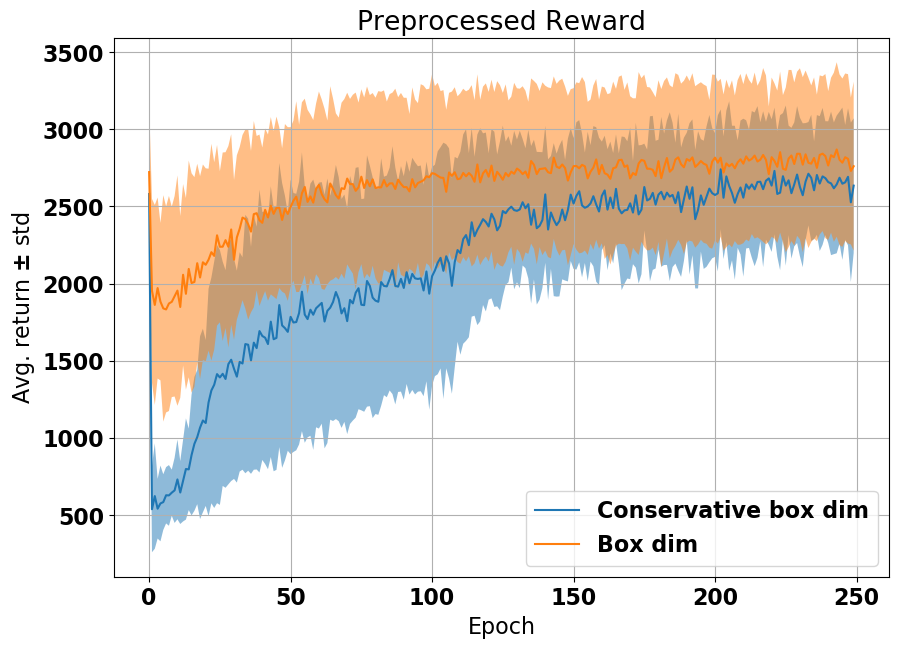

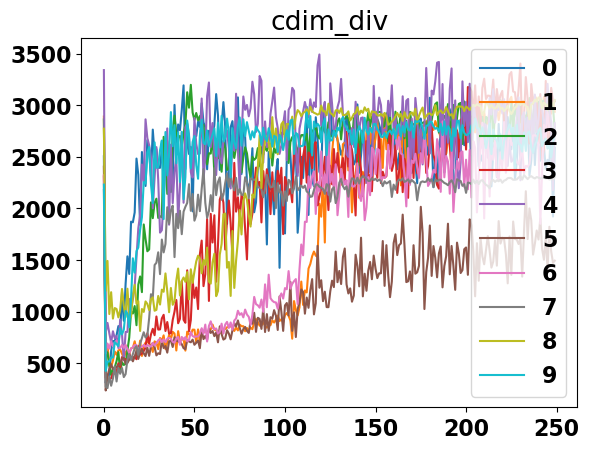

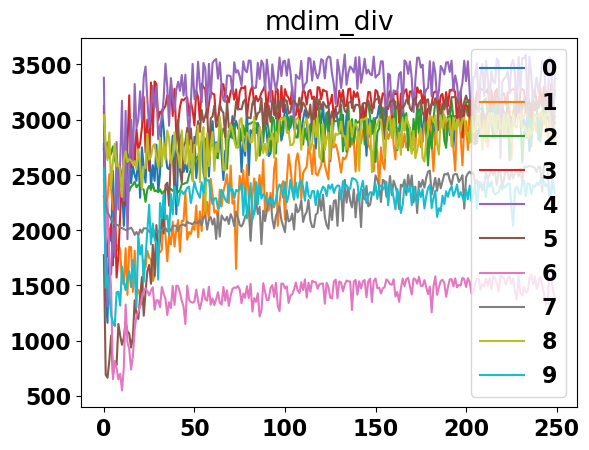

<Figure size 640x480 with 0 Axes>

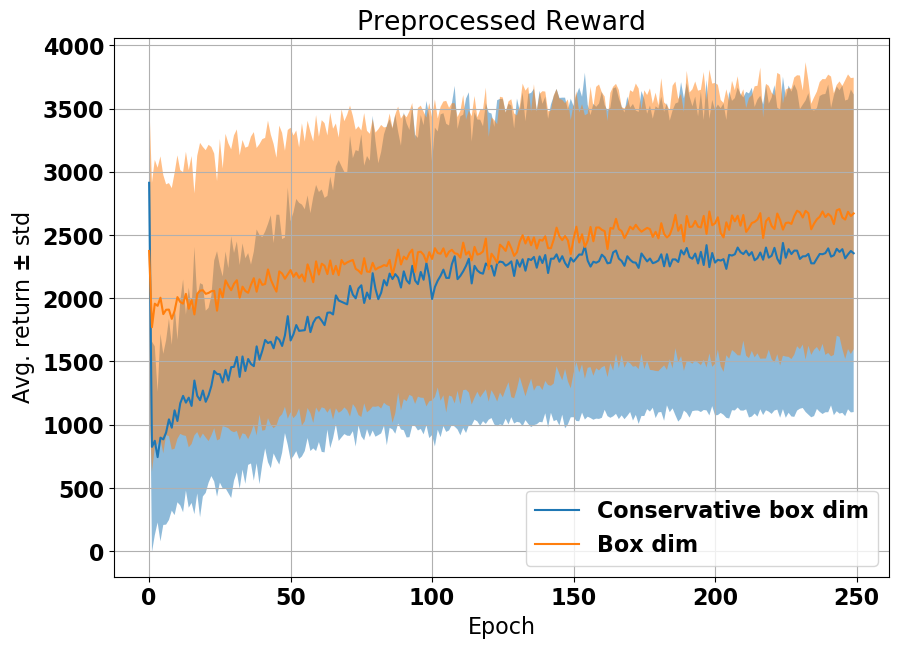

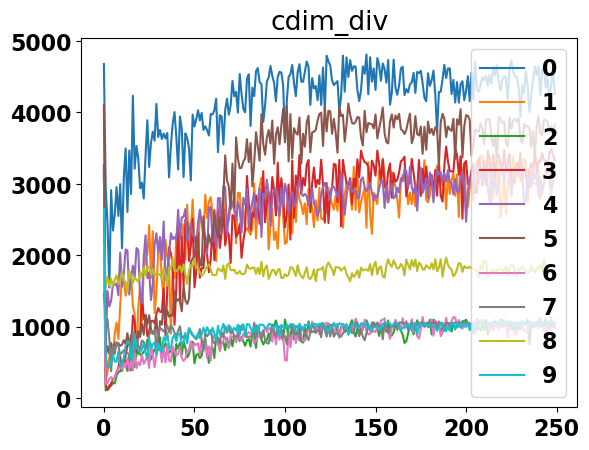

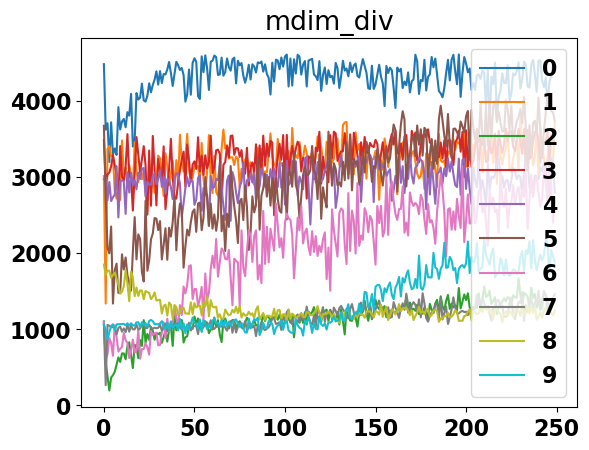

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib
env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]

matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
init_names = ["identity", "madodiv", "identity"]

for env_name, init_name in zip(env_names, init_names):
    init_data = torch.load(f"./data17/{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    policy_dict = data.policy_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    plt.subplots(1,1, figsize=(10,7))
    plt.plot(means.T)
    plt.legend(['Conservative box dim', 'Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    plt.title(f"Preprocessed Reward")
    plt.ylabel(r"Avg. return $\pm$ std")
    plt.xlabel(r"Epoch")
    plt.grid()
    plt.figure()

    
    for exp_name in exp_names:  
        plt.plot(rews.loc[exp_name].T[:,0:10])
        plt.legend([i for i in range(10)])
        plt.title(exp_name)
        plt.figure()
    

In [9]:
env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]
init_names = ["identity", "madodiv", "identity"]

#env_names = ["Walker2d-v2"]
#init_names = ["identity"]#, "identity"]

init_d = 1e-6
num_runs = 5; num_seeds=10
ep_length= 1000

post_names= ['cdim_div', 'mdim_div']
post_fns = [cdim_div, mdim_div]

walking_seeds = {'cdim_div': [0,1,3,4,5,8], 'mdim_div':[0,1,3,4,5,6,8,9]}

for env_name, init_name in zip(env_names, init_names):
    env = gym.make(env_name)
    init_data = torch.load(f"./data17/{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    policy_dict = data.policy_dict
        
    mshdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rews =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    
    for post_fn in post_fns:
        for i in walking_seeds[post_fn.__name__]:
            for j in range(num_runs):
                policy = policy_dict[post_fn.__name__][i]
                o,a,r,l = do_long_rollout(env, policy, ep_length=ep_length)
                target = o[200:]
                target = (target - policy.state_means)/(policy.state_std)
             
                rews.loc[post_fn.__name__,i,j] = sum(r).item()

                mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d)
                mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
                vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
                rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                
    
#     for i in range(num_seeds):
#         for j in range(num_runs):
#             policy = init_policy_dict[init_name][i]
#             o,a,r,l = do_long_rollout(env, policy, ep_length=ep_length)
#             target = o[200:]
#             target = (target - policy.state_means)/(policy.state_std)

#             rews.loc[post_names[0],i,j] = sum(r).item()

#             mshdims.loc[post_names[0],i,j], cdims.loc[post_names[0],i,j] , _, _ = mesh_dim(target, init_d)
#             mdims.loc[post_names[0],i,j] = variation_dim(target)
#             vdims.loc[post_names[0],i,j] = variation_dim(target,order=2)
#             rdims.loc[post_names[0],i,j] = variation_dim(target,order=.5)
            
            

    print(f"{env_name}:")           
    print("madogram dimension")
    for name in post_names:
        mean = mdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = mdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for name in post_names:
        mean = vdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = vdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("rodogram dimension")
    for name in post_names:
        mean = rdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = rdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for name in post_names:
        mean = mshdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = mshdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for name in post_names:
        mean = cdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = cdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for name in post_names:
        mean = rews.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = rews.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print(); print()

running build_ext
HalfCheetah-v2:
madogram dimension
cdim_div mean: 1.409031973065342, std: 0.07628130478864949
mdim_div mean: 1.4133873892848006, std: 0.056204342329351245

variogram dimension
cdim_div mean: 1.7045159865326711, std: 0.03814065239432474
mdim_div mean: 1.7066936946424005, std: 0.02810217116467564

rodogram dimension
cdim_div mean: 0.818063946130684, std: 0.15256260957729895
mdim_div mean: 0.8267747785696014, std: 0.1124086846587025

mesh dimension
cdim_div mean: 0.7336665451966539, std: 1.1144947654833444
mdim_div mean: 0.905532458255724, std: 0.520648736247438

cmesh dimension
cdim_div mean: 2.2333236187536634, std: 1.0719040567822096
mdim_div mean: 2.6644901183486027, std: 1.325852437686909

rewards
cdim_div mean: 4011.830037434896, std: 325.04980118682954
mdim_div mean: 4718.330679321289, std: 1229.15087394949


Hopper-v2:
madogram dimension
cdim_div mean: 1.0288912447992646, std: 0.01730801776724503
mdim_div mean: 1.0571299444809963, std: 0.0422052208251004

variogr

In [175]:
env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]
init_names = ["identity", "madodiv", "identity"]

init_d = 1e-6
num_runs = 5; num_seeds=10
ep_length= 10000


post_names= ['init', 'cdim_div', 'mdim_div']
post_fns = [cdim_div, mdim_div]


for env_name, init_name in zip(env_names, init_names):
    env = gym.make(env_name)
    init_data = torch.load(f"./data17/{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    policy_dict = data.policy_dict
        
    mshdims = xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    cdims =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    vdims = xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    mdims = xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rdims =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rews =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    
    for post_fn in post_fns:
        for i in range(num_seeds):
            for j in range(num_runs):
                policy = policy_dict[post_fn.__name__][i]
                o,a,r,l = do_long_rollout(env, policy, ep_length=ep_length)
                target = o[200:]
                target = (target - target.mean(dim=0))/target.std(dim=0)

                #target = (target - policy.state_means)/(policy.state_std)
             
                rews.loc[post_fn.__name__,i,j] = sum(r).item()

                mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d)
                mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
                vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
                rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                
    
    for i in range(num_seeds):
        for j in range(num_runs):
            policy = init_policy_dict[init_name][i]
            o,a,r,l = do_long_rollout(env, policy, ep_length=ep_length)
            target = o[200:]
            #target = (target - policy.state_means)/(policy.state_std)
            target = (target - target.mean(dim=0))/target.std(dim=0)


            rews.loc[post_names[0],i,j] = sum(r).item()

            mshdims.loc[post_names[0],i,j], cdims.loc[post_names[0],i,j] , _, _ = mesh_dim(target, init_d)
            mdims.loc[post_names[0],i,j] = variation_dim(target)
            vdims.loc[post_names[0],i,j] = variation_dim(target,order=2)
            rdims.loc[post_names[0],i,j] = variation_dim(target,order=.5)
            
            
    
    print(f"{env_name}:")           
    print("madogram dimension")
    for name in post_names:
        mean = mdims.mean(dim=('seed','run')).loc[name].item()
        std = mdims.std(dim=('seed','run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for name in post_names:
        mean = vdims.mean(dim=('seed','run')).loc[name].item()
        std = vdims.std(dim=('seed','run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("rodogram dimension")
    for name in post_names:
        mean = rdims.mean(dim=('seed','run')).loc[name].item()
        std = rdims.std(dim=('seed','run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for name in post_names:
        mean = mshdims.mean(dim=('seed','run')).loc[name].item()
        std = mshdims.std(dim=('seed','run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for name in post_names:
        mean = cdims.mean(dim=('seed', 'run')).loc[name].item()
        std = cdims.std(dim=('seed', 'run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for name in post_names:
        mean = rews.mean(dim=('seed', 'run')).loc[name].item()
        std = rews.std(dim=('seed', 'run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print(); print()

HalfCheetah-v2:
madogram dimension
init mean: 1.4203810268002905, std: 0.04448428614900553
cdim_div mean: 1.4145938374696683, std: 0.058361442340771306
mdim_div mean: 1.416916230693935, std: 0.057773470721354594

variogram dimension
init mean: 1.7101905134001454, std: 0.022242143074502747
cdim_div mean: 1.7072969187348344, std: 0.029180721170385657
mdim_div mean: 1.7084581153469673, std: 0.028886735360677294

rodogram dimension
init mean: 0.8407620536005812, std: 0.08896857229801103
cdim_div mean: 0.8291876749393369, std: 0.11672288468154263
mdim_div mean: 0.8338324613878696, std: 0.11554694144270918

mesh dimension
init mean: 2.4465412009916006, std: 0.6693660246893298
cdim_div mean: 1.1535938888042265, std: 1.2510961774029674
mdim_div mean: 0.6591200716608341, std: 0.5280505581682334

cmesh dimension
init mean: 5.822476137344044, std: 1.0178426625276706
cdim_div mean: 3.229228060817216, std: 1.922363027130514
mdim_div mean: 2.7593531754253893, std: 1.179005229905685

rewards
init mea

# Export to matlab

In [79]:
env_name = "Hopper-v2"
data = torch.load(f"./data17/{env_name}.xr")

policy_dict = data.policy_dict
rews = data.rews#/data.post_rews
exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict[exp_names[0]])
env = gym.make(env_name)

for post_name in ['identity', 'madodiv', 'variodiv', 'radodiv']: #seed = 10
    for seed in range(num_seeds):
        for run in [0,1,2,3,4]:
            o,a,r,l = do_long_rollout(env,policy_dict[post_name][seed], ep_length=10000)

            #print("reward:", sum(r))
            #print("variation_dim: ", variation_dim(o))
            #print("roughness: ", rough_measure(o))
            #plt.plot(o)
            #plt.figure()
            #plt.plot(a)

            import scipy.io 
            import os

            o = np.array(o)
            a = np.array(a)
            r = np.array(r)
            os.makedirs(f"./data/k2/env_{env_name}/post_{post_name}/seed_{seed}", exist_ok=True)
            scipy.io.savemat(f"./data/k2/env_{env_name}/post_{post_name}/seed_{seed}/run_{run}.mat", mdict = {"obs":o, "act":a, "rew":r})

KeyboardInterrupt: 